# Time-Series Analysis

## Environment set up

Change the working directory to be able to work with the source-code.

In [1]:
import os
from pathlib import Path

WORKING_DIRECTORY = Path.cwd().parents[0]
os.chdir(WORKING_DIRECTORY)
os.getcwd()

'C:\\python\\personal\\nasa-bearings'

## Imports

In [2]:
from src.read import read_nasa_vibration_files_in_directory
from src.signals import get_resolution
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from loguru import logger

## Inputs

The inputs have been obtained from the NASA bearings documentation:

In [3]:
INPUTS = {
    '1st_test': {'data_path': r'data\1st_test\1st_test',
                  'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4',
                                   'channel_5', 'channel_6', 'channel_7', 'channel_8'],
                 'faulty_channels': ['channel_5', 'channel_6', 'channel_7', 'channel_8']},
    '2nd_test': {'data_path': r'data\2nd_test\2nd_test',
                 'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4'],
                 'faulty_channels': ['channel_1']},
    '3rd_test': {'data_path': r'data\3rd_test\4th_test\txt',
                 'column_names': ['channel_1', 'channel_2', 'channel_3', 'channel_4'],
                 'faulty_channels': ['channel_3']}
          }

In [4]:
SAMPLING_RATE_IN_HERTZ = 20000
MEASUREMENT_DURATION_IN_SECONDS = 1
ACCEPTABLE_SENSOR_RANGE = 0.01

# Read the data

In [5]:
complete_data_path_per_test = {}

for test, inputs_per_test in INPUTS.items():
    for key, values in inputs_per_test.items():
        data_path = inputs_per_test['data_path']
        complete_path = WORKING_DIRECTORY.joinpath(data_path)
        complete_data_path_per_test[test] = complete_path

complete_data_path_per_test

{'1st_test': WindowsPath('C:/python/personal/nasa-bearings/data/1st_test/1st_test'),
 '2nd_test': WindowsPath('C:/python/personal/nasa-bearings/data/2nd_test/2nd_test'),
 '3rd_test': WindowsPath('C:/python/personal/nasa-bearings/data/3rd_test/4th_test/txt')}

In [6]:
signal_resolution = get_resolution(sampling_frequency=SAMPLING_RATE_IN_HERTZ)

df_list_per_test = {}
for test, file_path in complete_data_path_per_test.items():
    logger.info(f'test: {test}')
    column_names = INPUTS[test]['column_names']
    df_list = read_nasa_vibration_files_in_directory(files_path=file_path, sensors=column_names,
                                                     signal_resolution=signal_resolution,
                                                     acceptable_sensor_range=ACCEPTABLE_SENSOR_RANGE)
    df_list_per_test[test] = df_list

2025-08-26 07:36:37.764 | INFO     | __main__:<module>:5 - test: 1st_test
2025-08-26 07:37:44.298 | INFO     | __main__:<module>:5 - test: 2nd_test
2025-08-26 07:38:18.786 | INFO     | src.read:read_nasa_vibration_files_in_directory:60 - All sensors in file 2004.02.19.06.12.39 are faulty for the defined acceptable_sensor_range of 0.01. Skipping this file.
2025-08-26 07:38:18.806 | INFO     | src.read:read_nasa_vibration_files_in_directory:60 - All sensors in file 2004.02.19.06.22.39 are faulty for the defined acceptable_sensor_range of 0.01. Skipping this file.
2025-08-26 07:38:18.807 | INFO     | __main__:<module>:5 - test: 3rd_test
2025-08-26 07:45:26.879 | INFO     | src.read:read_nasa_vibration_files_in_directory:60 - All sensors in file 2004.04.18.02.42.55 are faulty for the defined acceptable_sensor_range of 0.01. Skipping this file.


# Time-series plots

The following plots show the first and last available measurements to see see how the data changes for a bearing while changes from healthy to faulty:

test: 1st_test
test: 2nd_test
test: 3rd_test


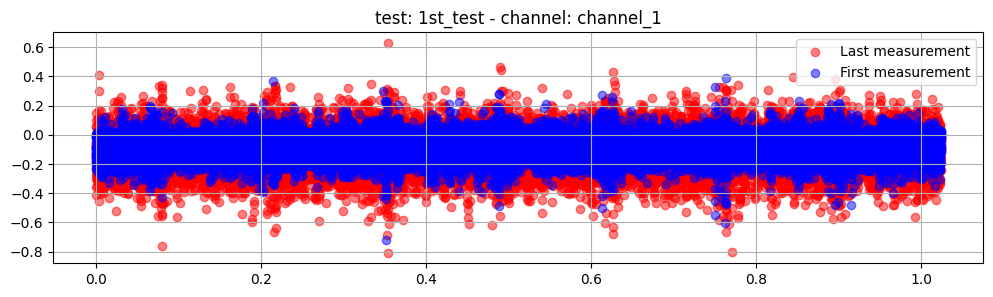

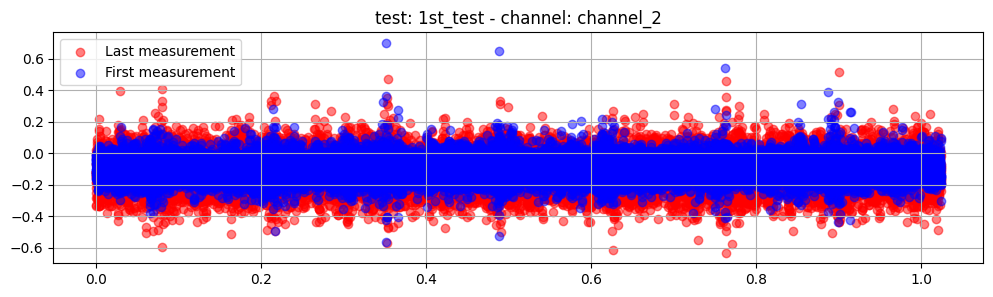

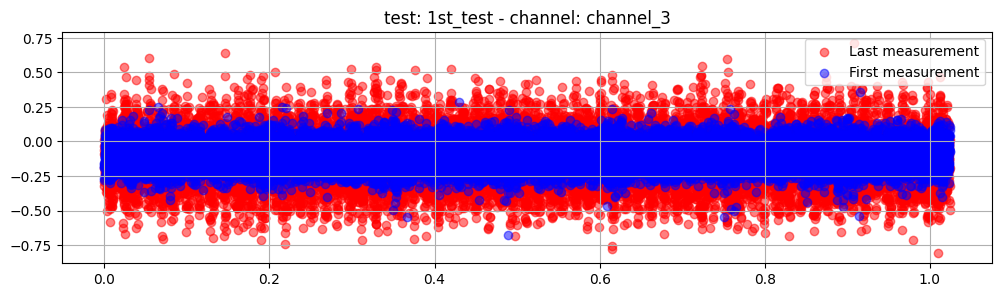

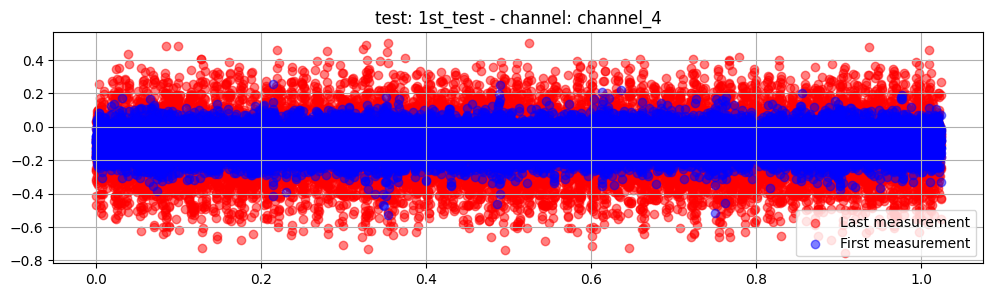

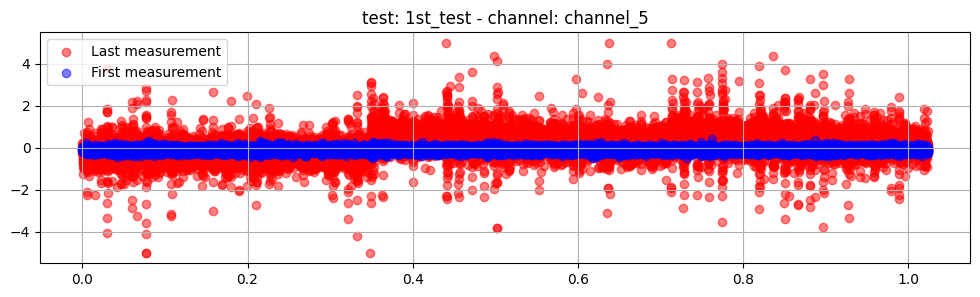

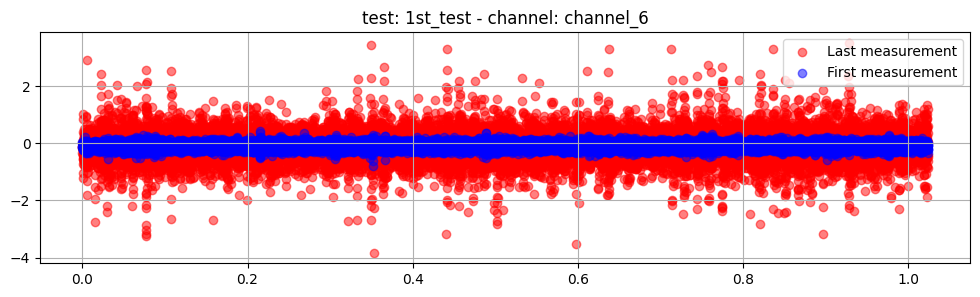

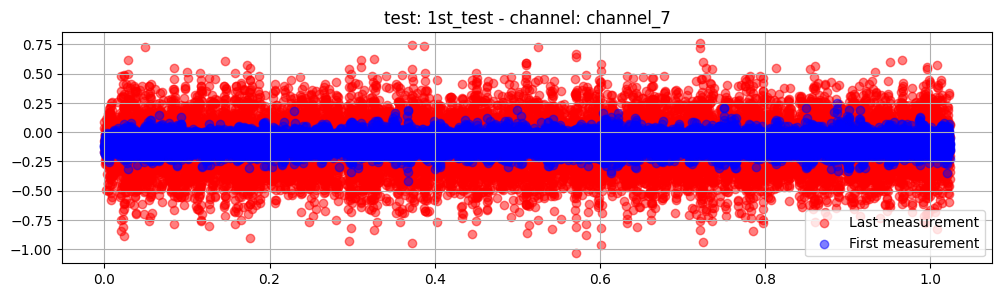

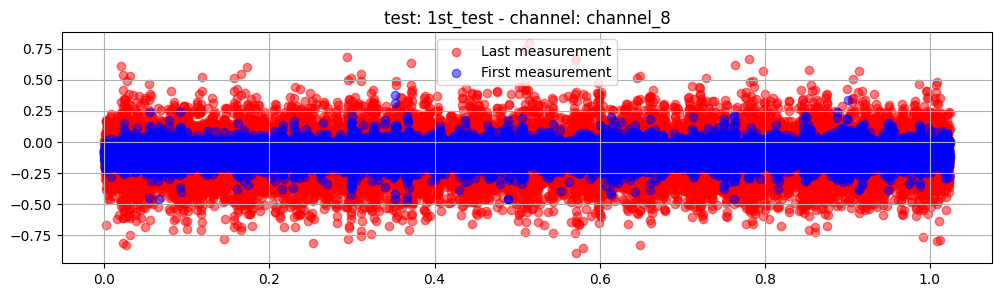

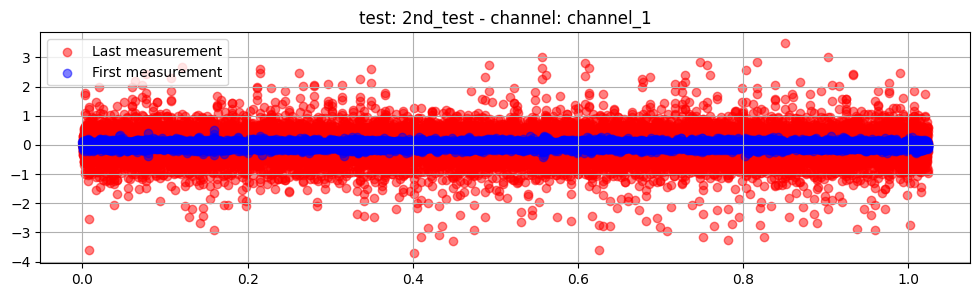

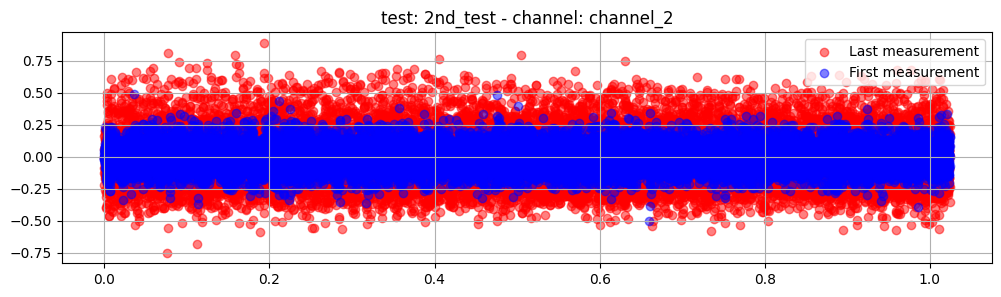

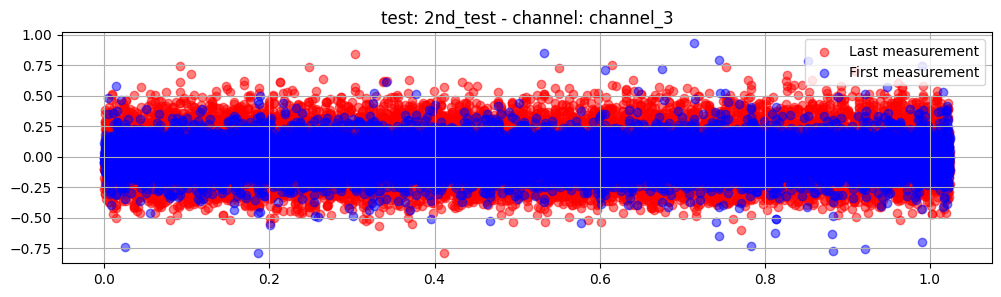

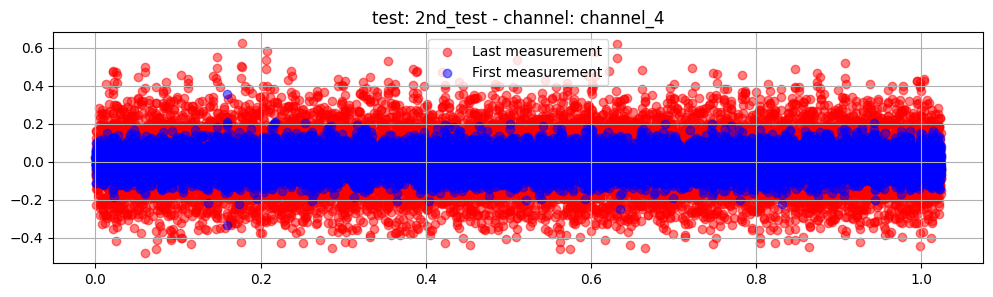

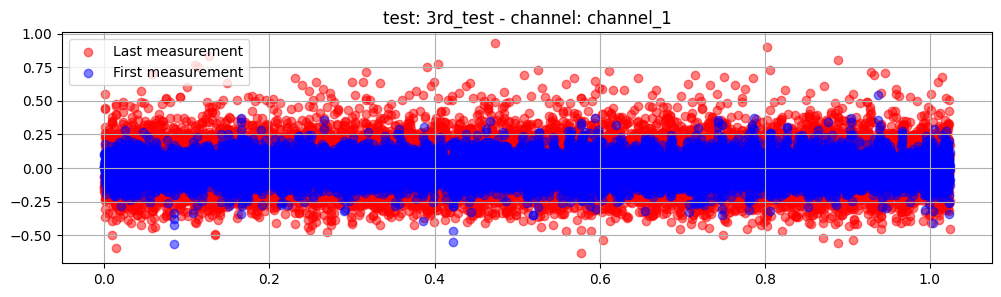

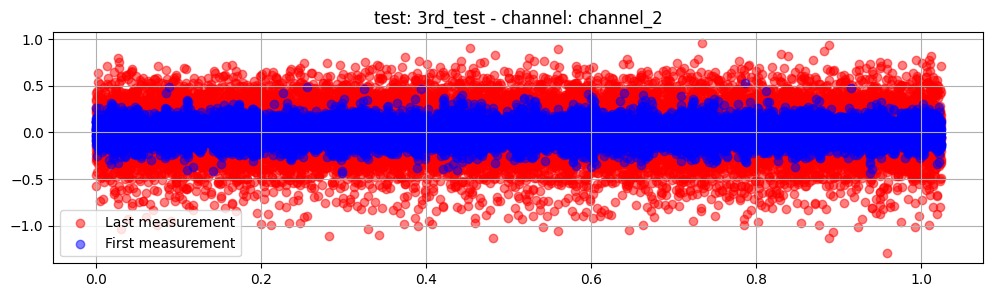

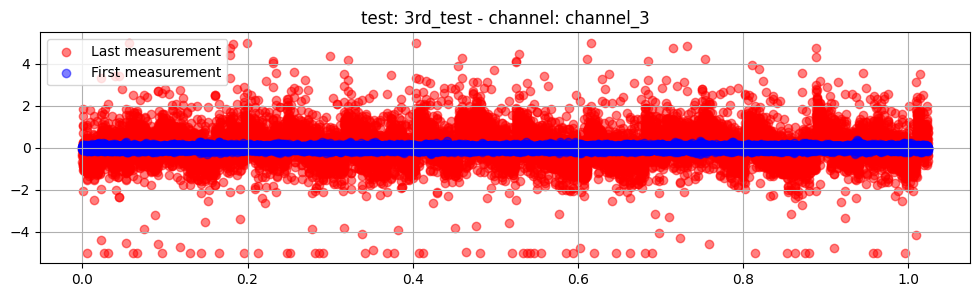

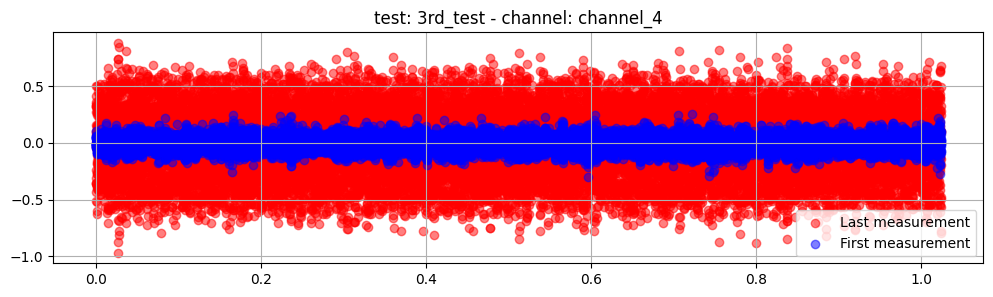

In [7]:
for test, df_list in df_list_per_test.items():
    print(f'test: {test}')
    column_names = INPUTS[test]['column_names']
    for channel in column_names:
        plt.figure(figsize=(12, 3))
        plt.scatter(df_list[-1]['measurement_time_in_seconds'], df_list[-1][channel], label='Last measurement', color='red', alpha=0.5)
        plt.scatter(df_list[0]['measurement_time_in_seconds'], df_list[0][channel], label='First measurement', color='blue', alpha=0.5)
        plt.legend()
        plt.grid()
        plt.title(f'test: {test} - channel: {channel}');

# Aggregation

Different aggregation functions are used to better understand the evolution of the failure using the time-series data:

In [8]:
AGGREGATION_FUNCTIONS = [
    ('mean', 'mean'),
    ('std', 'std'),
    ('max', 'max'),
    ('min', 'min'),
    ('median', 'median'),
    ('mode', lambda x: x.mode().iloc[0] if not x.mode().empty else None),
    ('q1', lambda x: x.quantile(0.25)),
    ('q2', lambda x: x.quantile(0.50)),  # same as median
    ('q3', lambda x: x.quantile(0.75)),
    ('q4', lambda x: x.quantile(1.0)),
    ('range', lambda x: x.max() - x.min())
]

In [9]:
aggregated_df_per_test = {}

for test, df_list in df_list_per_test.items():
    print(f'test: {test}')
    df = pd.concat(df_list, ignore_index=True)
    faulty_channels = INPUTS[test]['faulty_channels']
    aggregated_df = (
    df.groupby('file_name')[faulty_channels]
      .agg(AGGREGATION_FUNCTIONS)
      .reset_index()
    )

    # Flatten MultiIndex cleanly
    aggregated_df.columns = [
        "_".join([str(c) for c in col if c]).rstrip("_")
        for col in aggregated_df.columns.to_flat_index()
    ]

    # Convert file_name into datetime
    aggregated_df['date_time'] = pd.to_datetime(
        aggregated_df['file_name'], format="%Y.%m.%d.%H.%M.%S"
    )

    aggregated_df_per_test[test] = aggregated_df


test: 1st_test
test: 2nd_test
test: 3rd_test


C:\Users\ikdlo\AppData\Local\Temp\ipykernel_20772\2248771192.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 2.5))


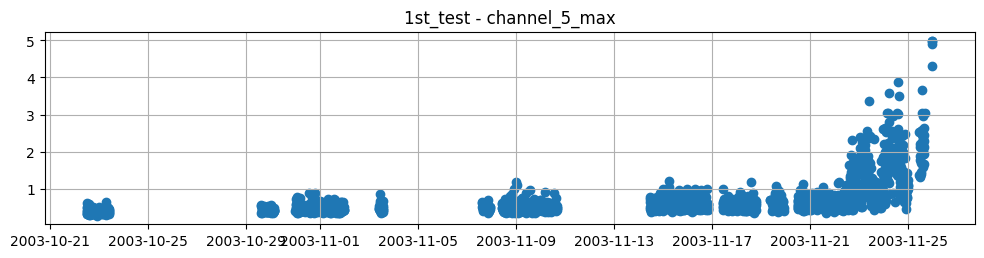

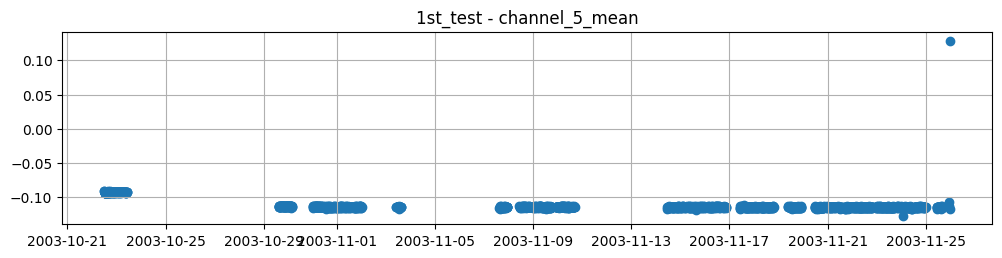

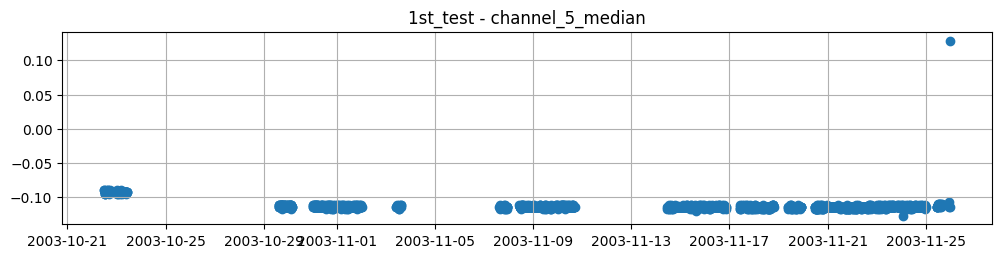

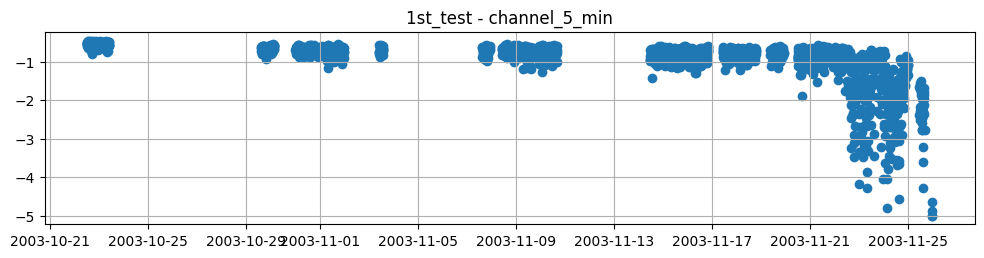

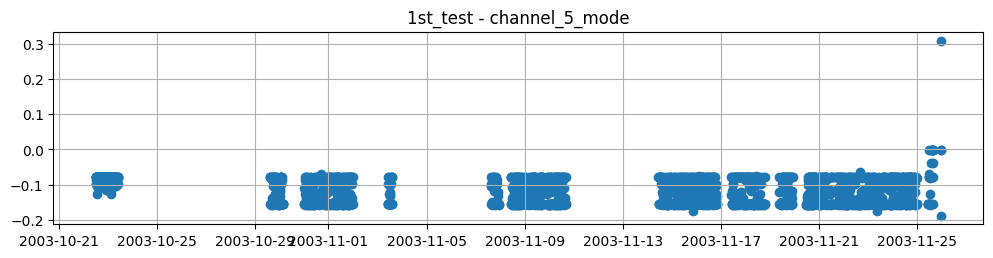

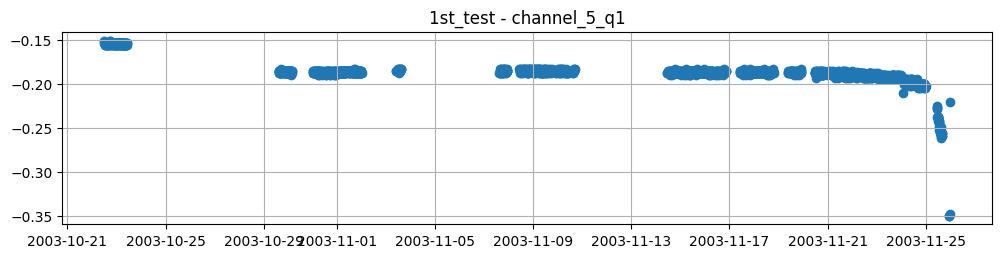

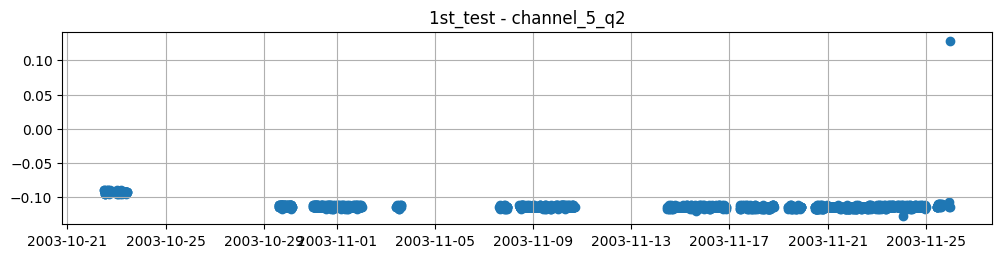

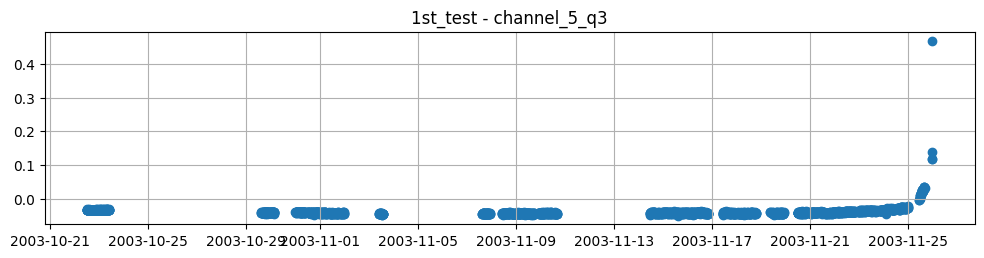

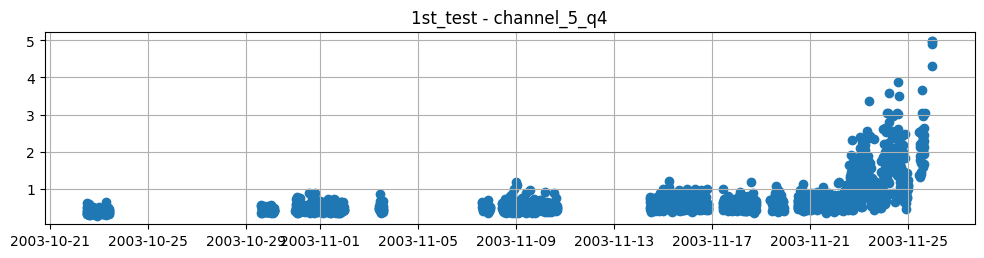

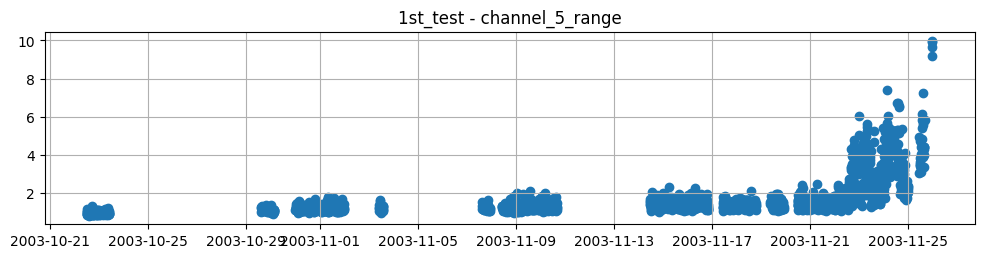

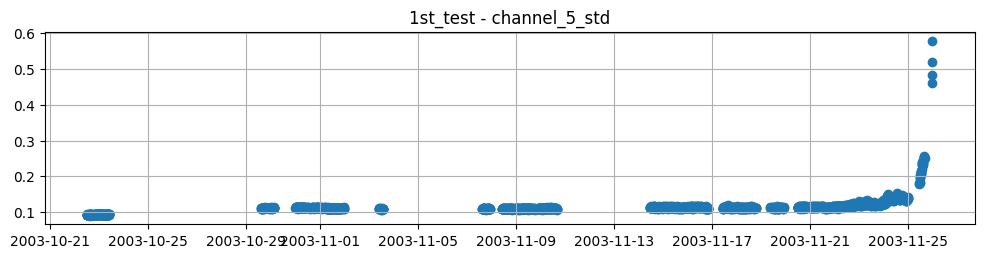

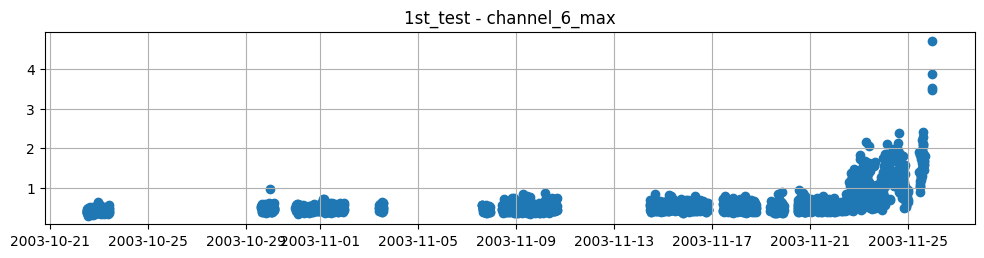

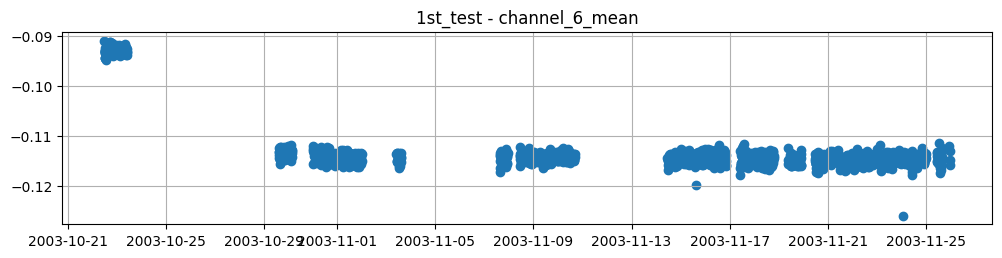

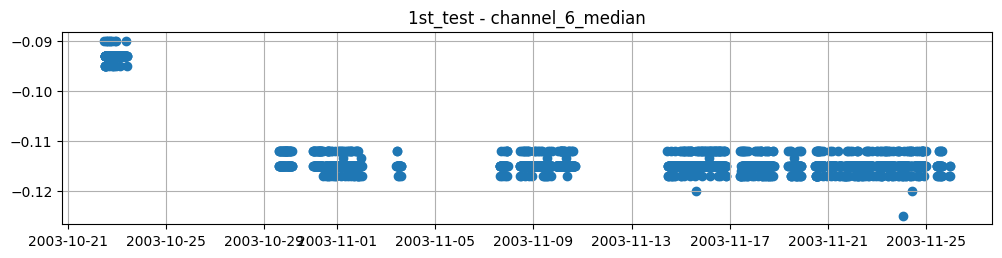

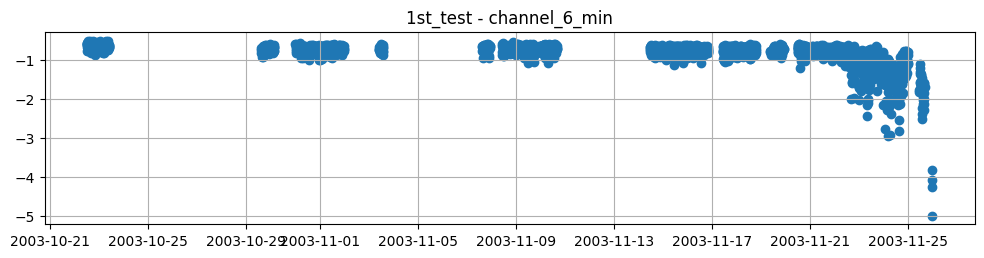

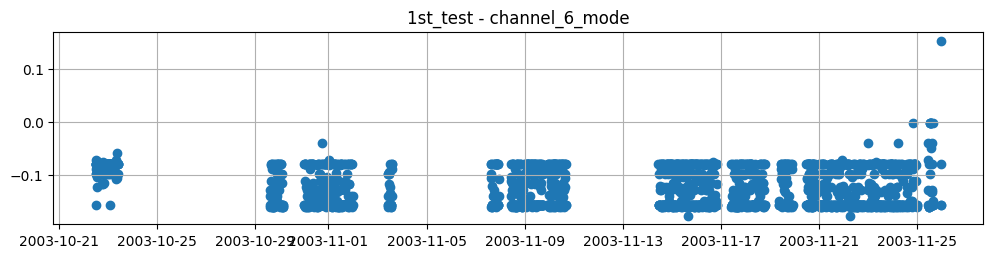

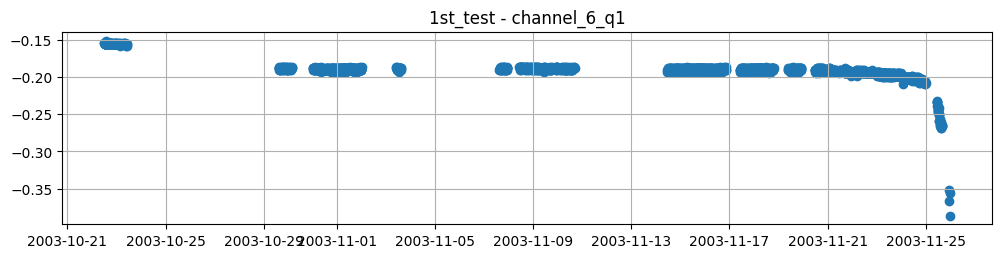

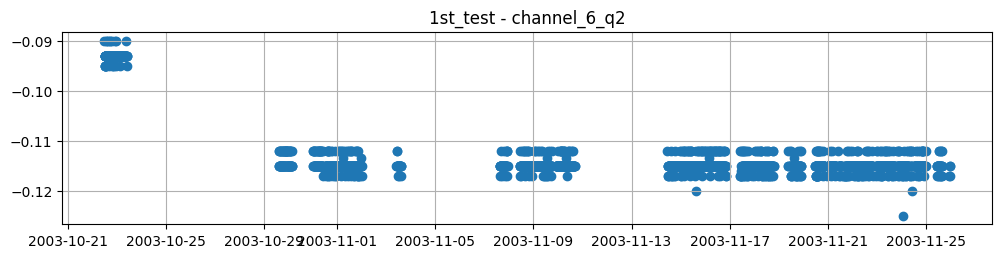

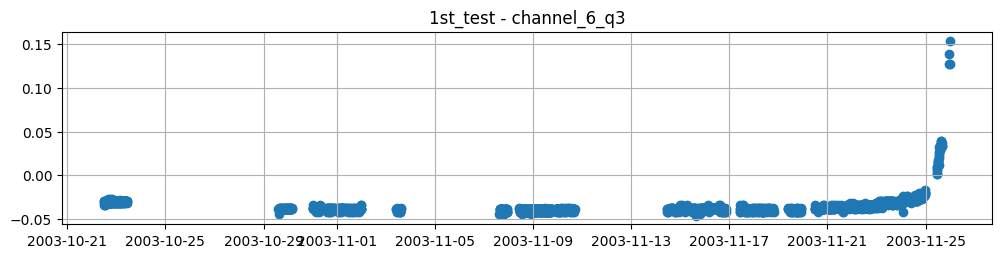

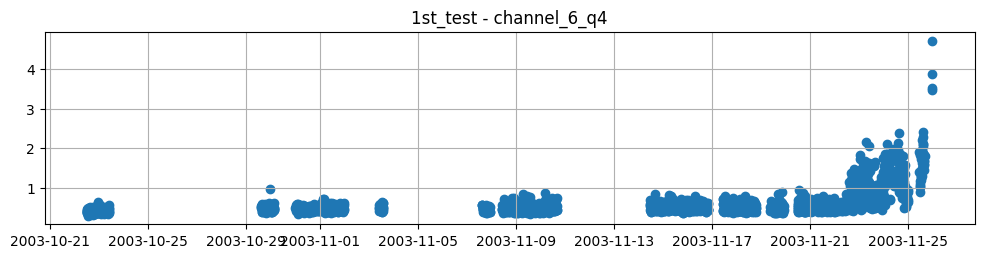

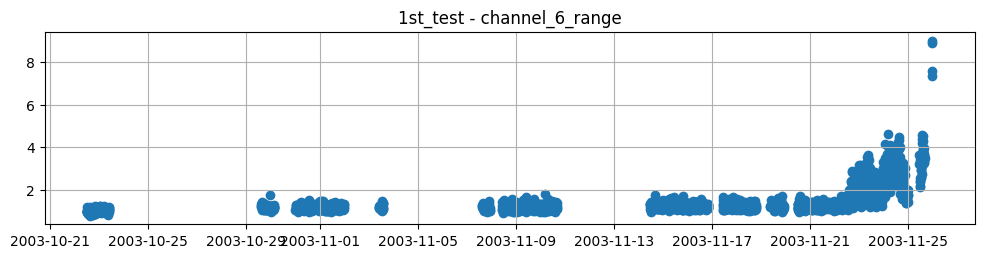

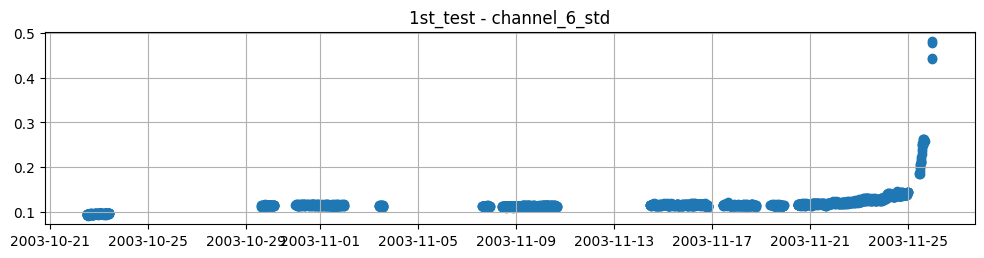

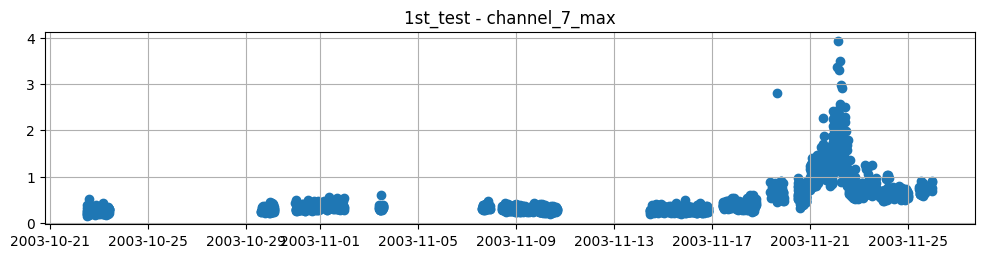

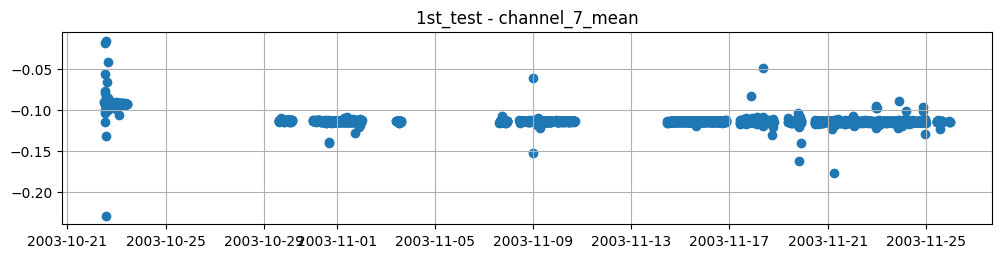

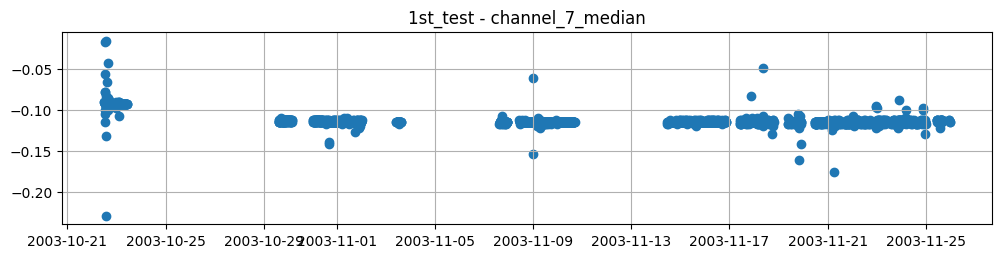

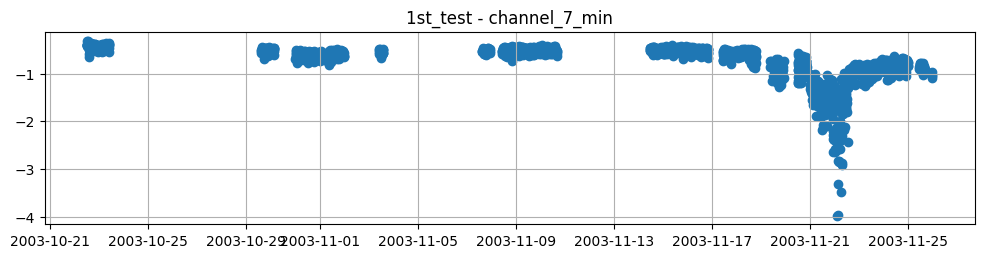

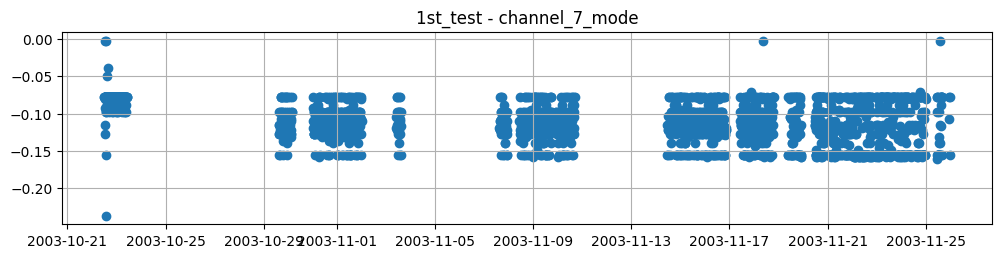

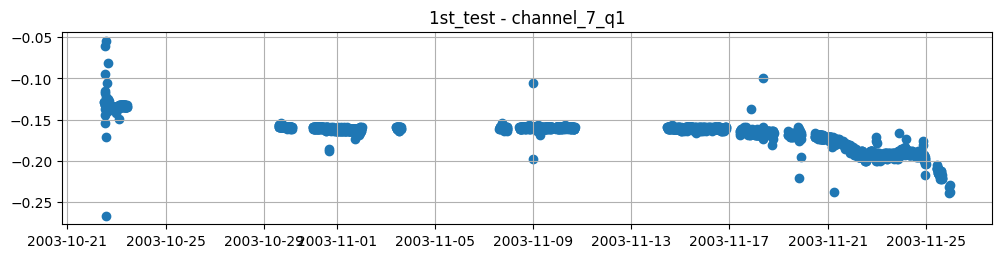

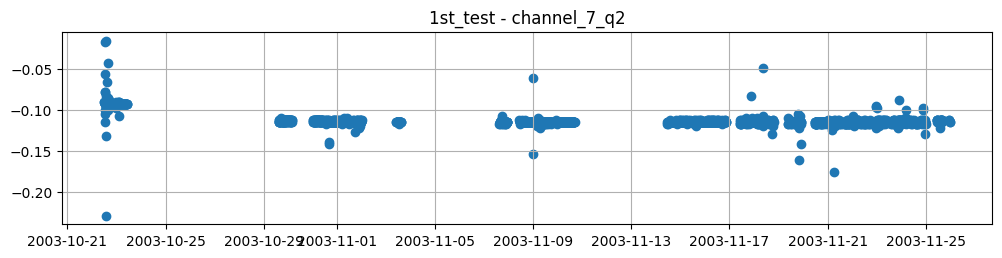

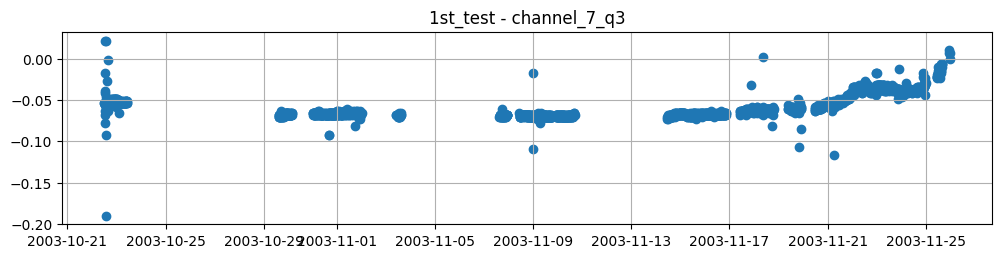

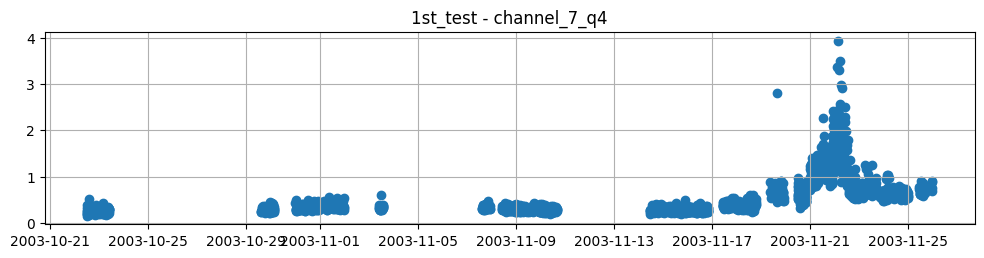

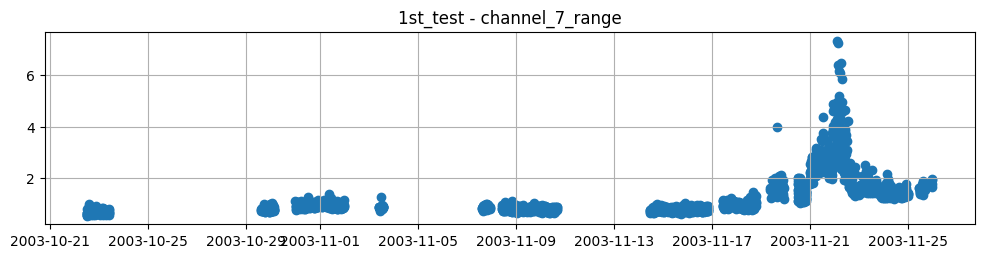

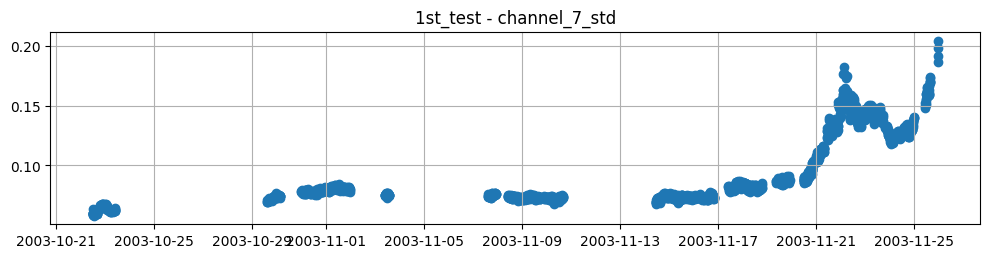

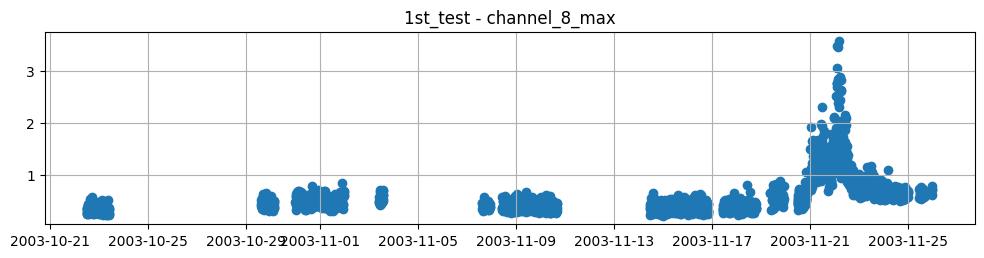

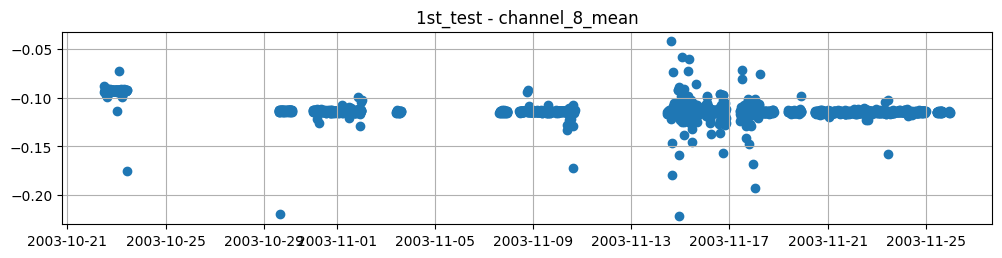

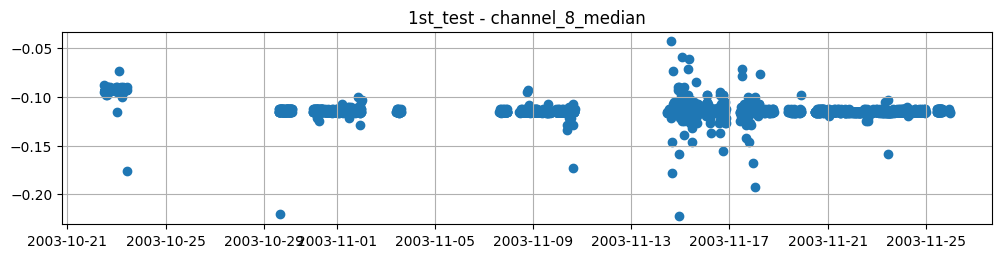

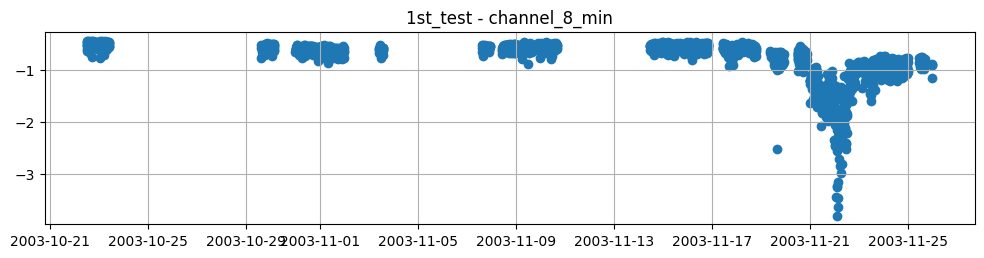

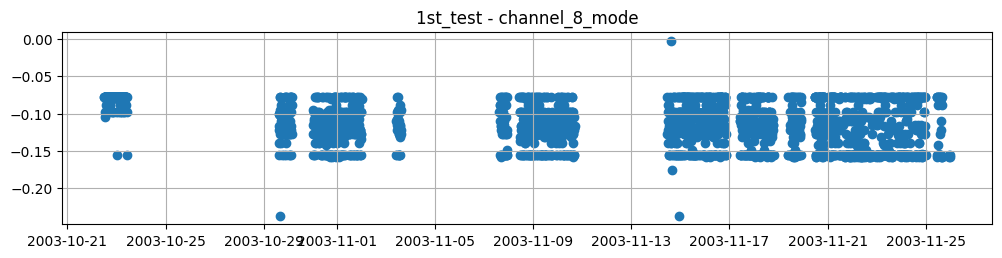

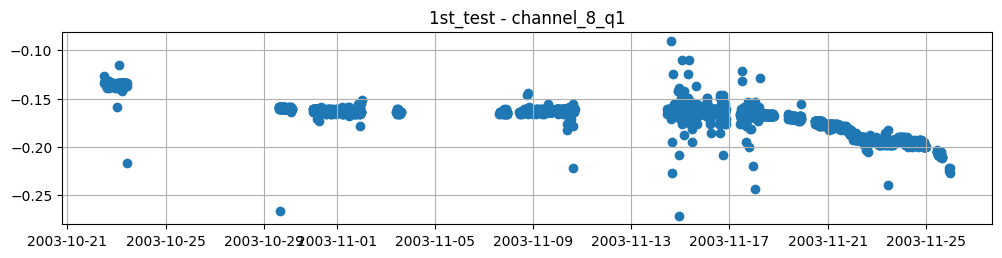

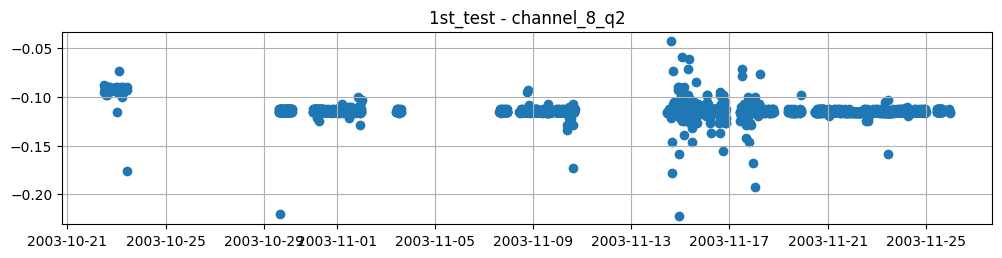

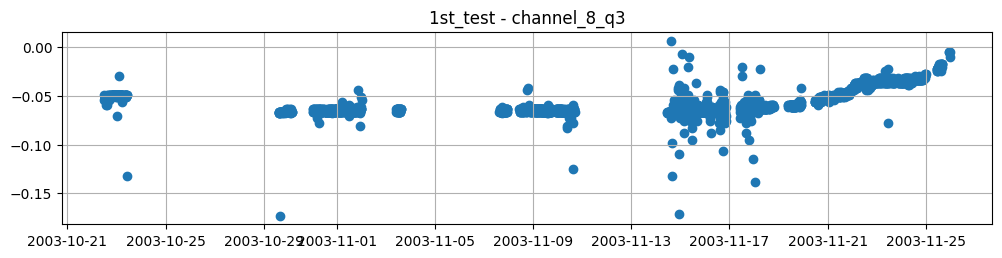

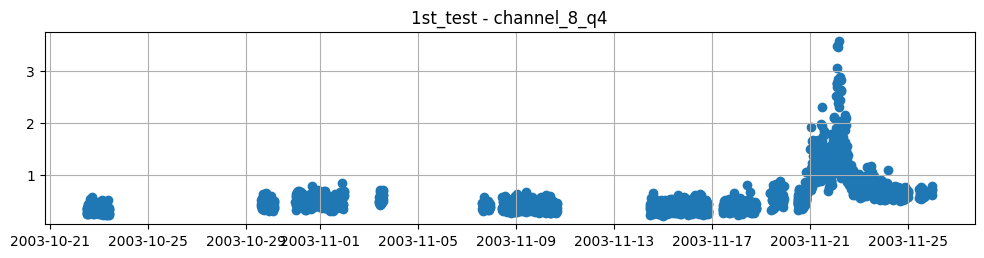

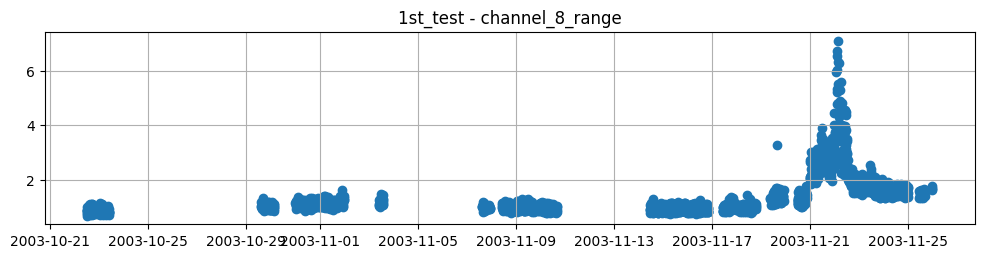

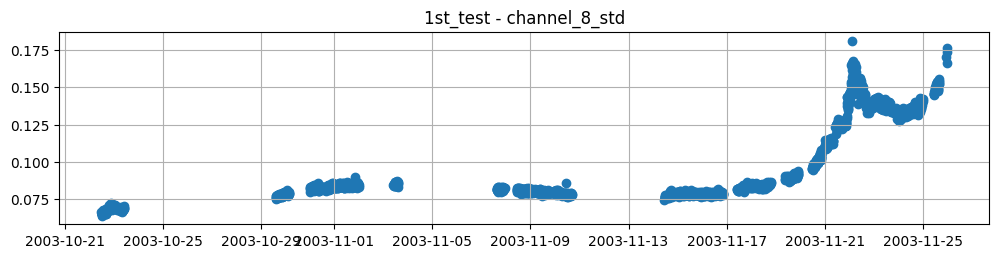

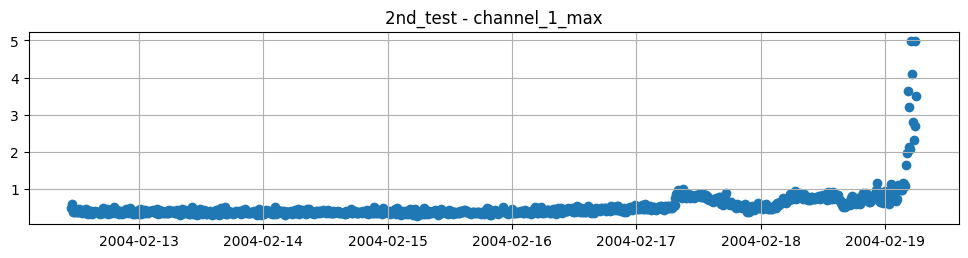

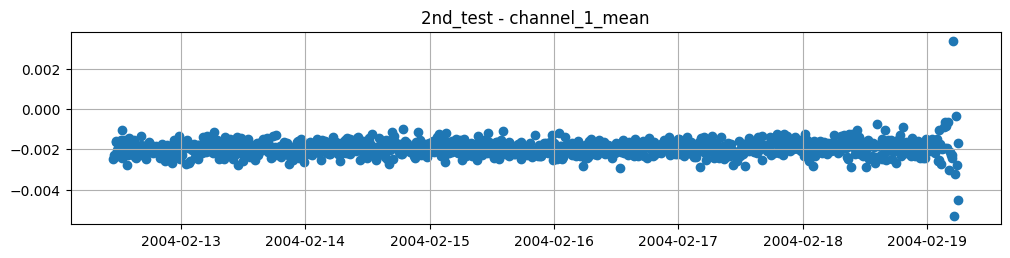

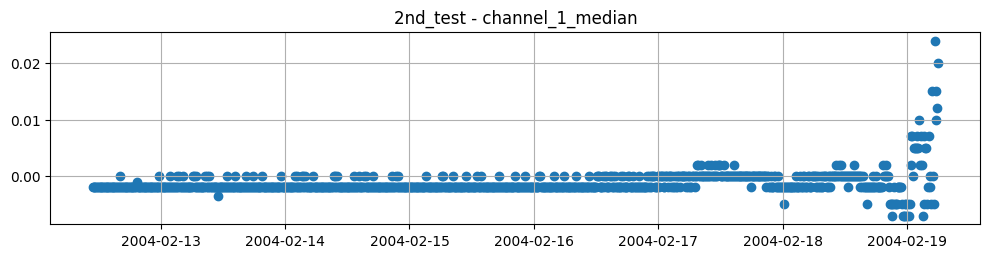

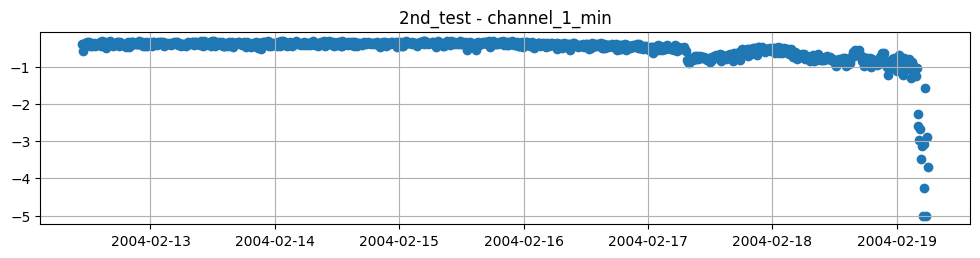

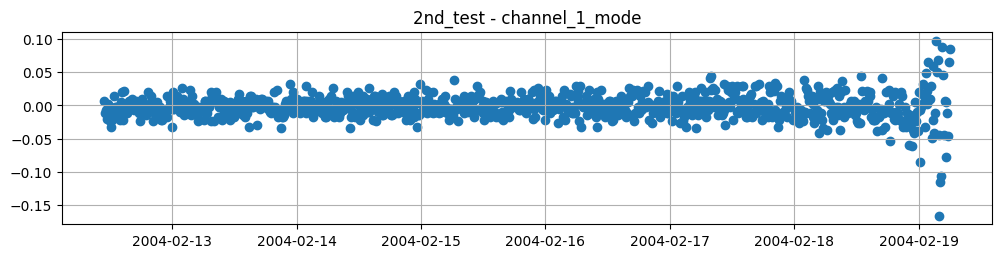

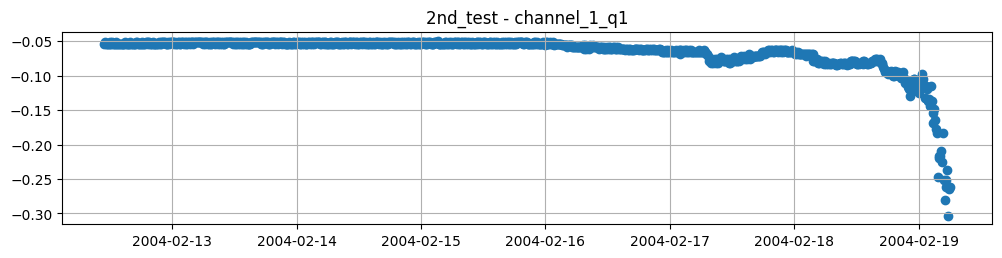

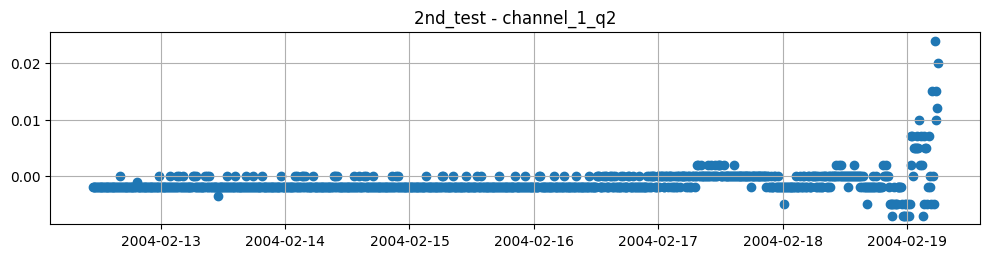

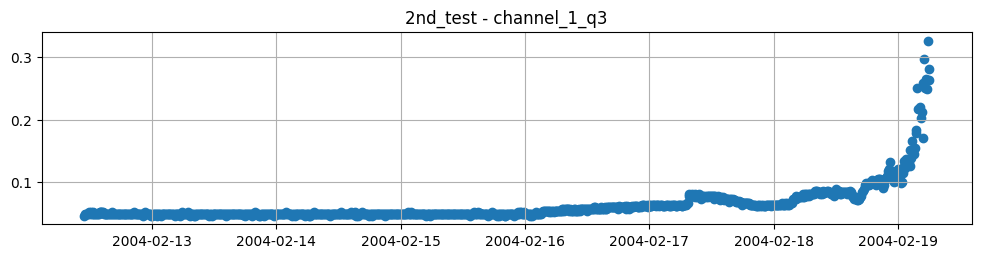

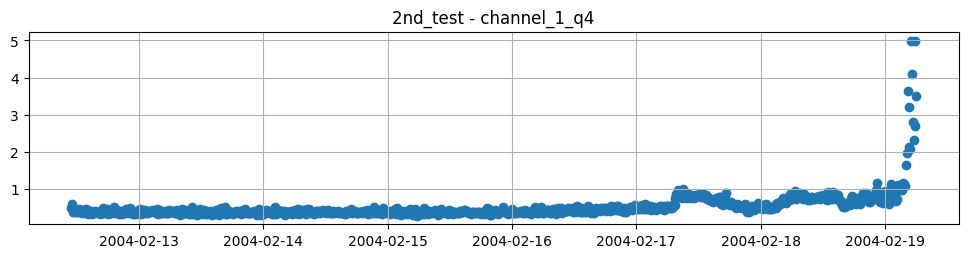

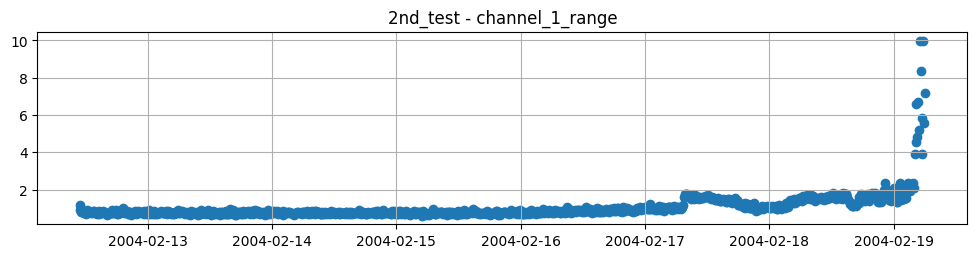

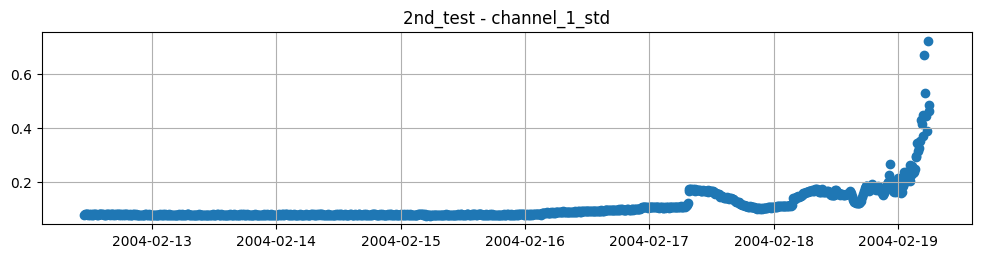

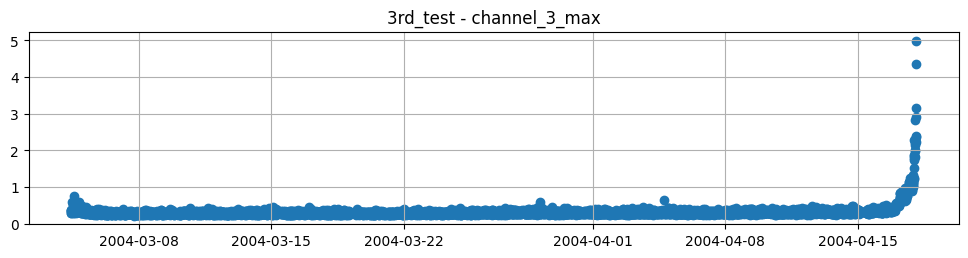

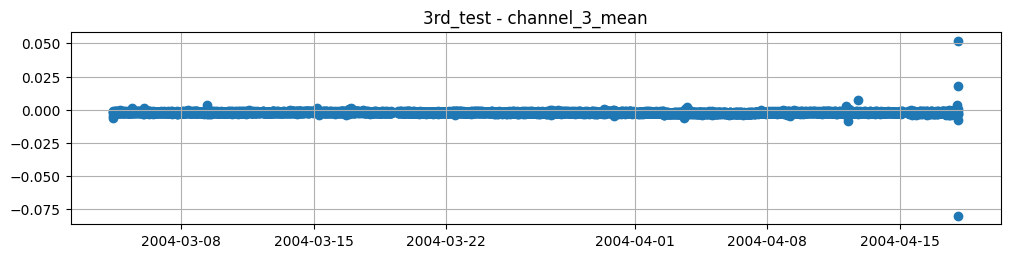

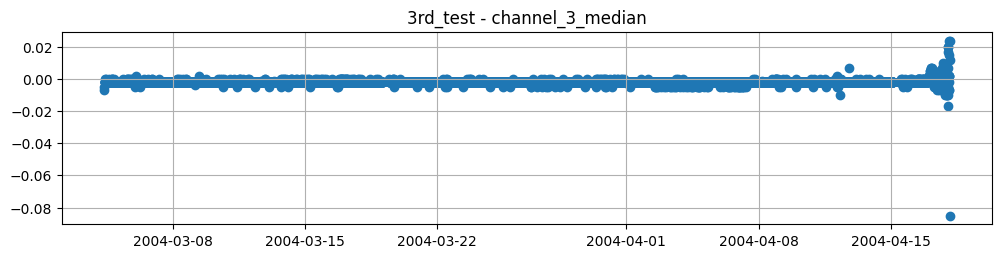

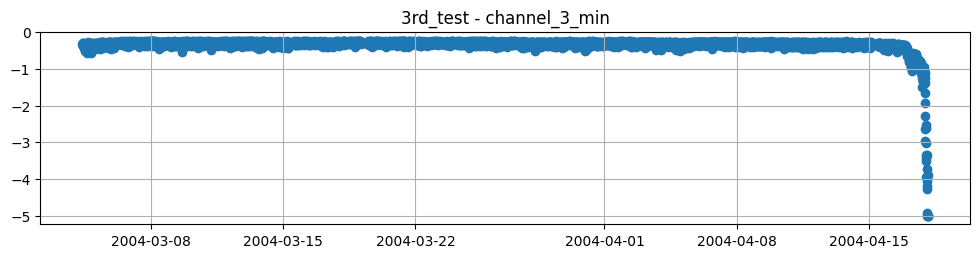

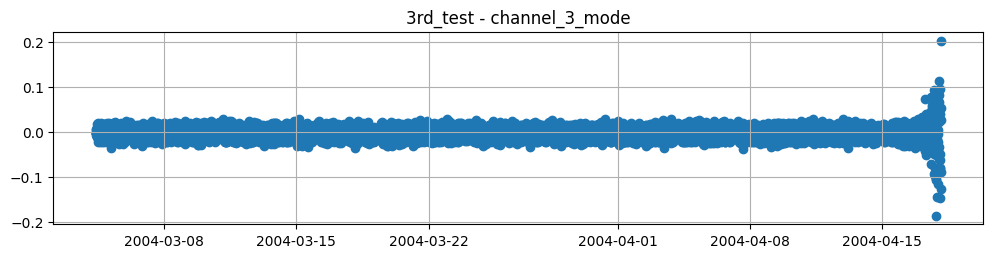

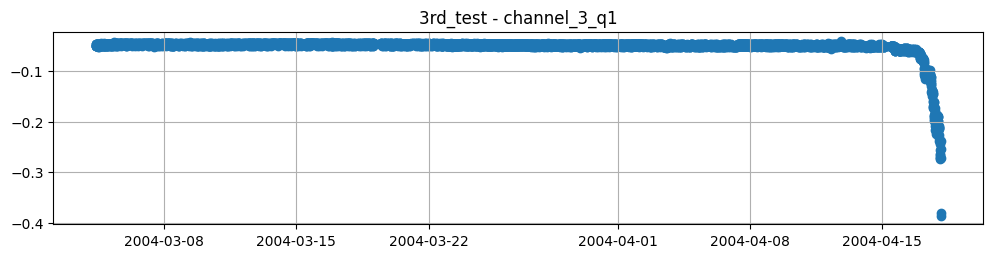

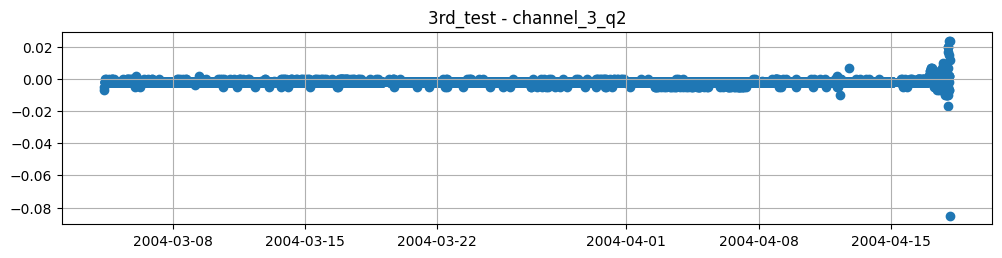

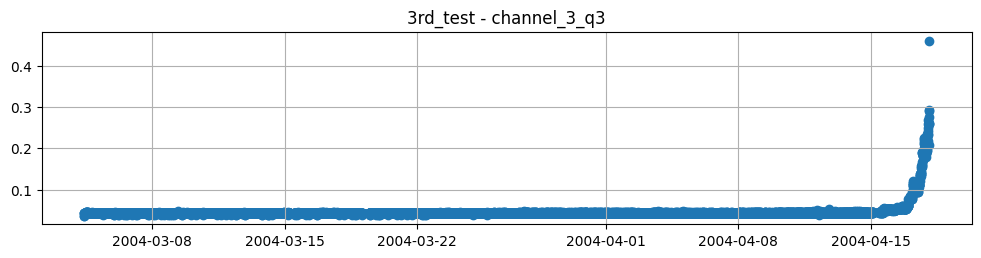

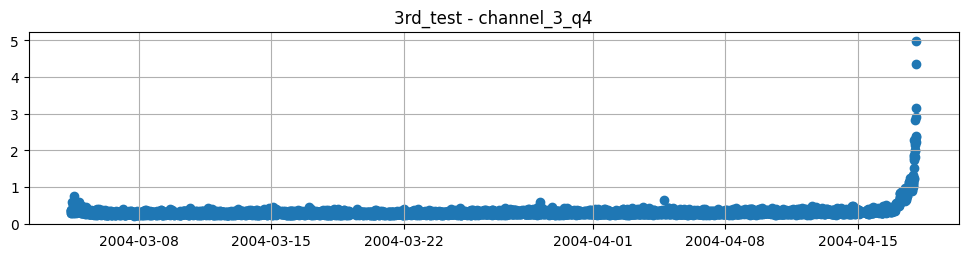

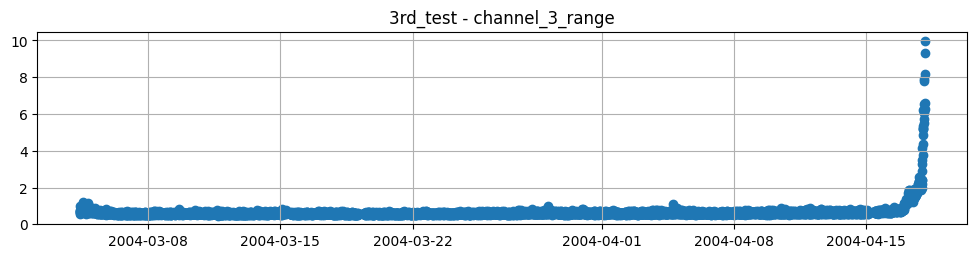

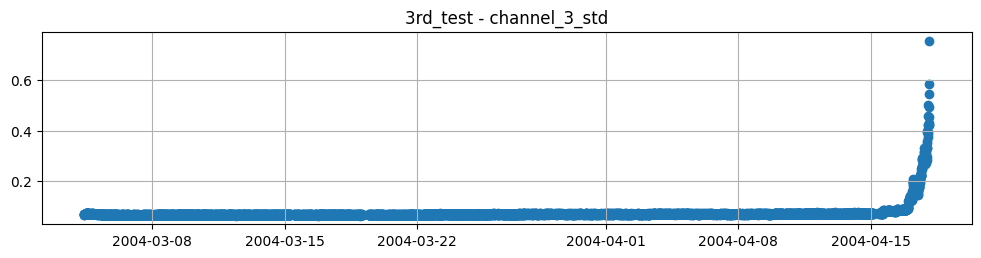

In [10]:
for test, aggregated_df in aggregated_df_per_test.items():
    plot_columns = np.sort(np.array([i for i in aggregated_df.columns if 'channel' in i]))

    for plot_column in plot_columns:
        plt.figure(figsize=(12, 2.5))
        plt.scatter(aggregated_df['date_time'], aggregated_df[plot_column])
        plt.title(f'{test} - {plot_column}')
        plt.grid()